In [50]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import itertools
import matplotlib.patheffects as path_effects

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [51]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = plt.text(j, i, "{:d}\n({:0.4f})".format(int(cm[i, j]), cm_normalized[i, j]),
                     horizontalalignment="center",
                     color="white")
            
        txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [2]:
amazon_baby_train_location = './Sentiment-Analysis-Data/Amazon_baby/Amazon_baby_train.txt'
with open(amazon_baby_train_location, encoding='UTF-8') as f:
    lines = f.readlines()
    train_ratings = []
    train_texts = []
    for text in lines:
        text = text.split(' ; ')
        train_ratings.append(int(float(text[0])))
        train_texts.append(text[2].lower())
train_ratings = np.array(train_ratings)-1

In [3]:
train_texts, eval_texts, train_ratings, eval_ratings = train_test_split(train_texts, train_ratings, test_size=0.2, random_state=42, shuffle=True)

In [4]:
amazon_baby_test_location = './Sentiment-Analysis-Data/Amazon_baby/Amazon_baby_test.txt'
with open(amazon_baby_test_location, encoding='UTF-8') as f:
    lines = f.readlines()
    test_ratings = []
    test_texts = []
    for text in lines:
        text = text.split(' ; ')
        test_ratings.append(int(float(text[0])))
        test_texts.append(text[2].lower())
test_ratings = np.array(test_ratings)-1

In [5]:
print(f'Train size: {len(train_texts)}')
print(f'Eval size: {len(eval_texts)}')
print(f'Test size: {len(test_texts)}')

Train size: 117488
Eval size: 29373
Test size: 36670


In [6]:
train_ratings[:40]

array([3, 2, 4, 3, 4, 4, 3, 3, 4, 3, 3, 4, 1, 3, 4, 4, 0, 3, 1, 0, 4, 3,
       0, 4, 2, 4, 4, 3, 4, 4, 3, 3, 1, 4, 4, 4, 4, 3, 2, 4])

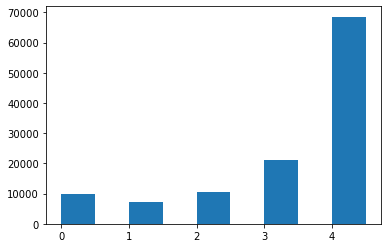

In [7]:
fig, ax = plt.subplots()
_ = ax.hist(train_ratings, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

In [9]:
train_texts[:2]

[" these are great, they work really well and come in very handy when water is not available to clean parts. however, 50 cents for one wipe is outrageous. i obviously knew that buying the product but i still feel like it's a necessary item to have for occasional use. i guess medela must be making a 1000% margin on this one. imagine if baby wipes were as expensive, no one would buy them! medela should really rethink their pricing policy on this one, there's no reason these should be any more expensive than baby wipes.\n",
 " i bought this pillow based on the high reviews.  it's not a bad pillow, but it definitely isn't as great as i was expecting!  the first couple weeks with it, it was amazing!  but then, all the fluff started to flatten and no matter how hard i try to fluff it back up, nothing seems to work.  also, the top where you would put your head, the stuffing seems to be separating, so there's little to no support for your neck and head.  i started waking up with horrible heada

In [10]:
train_ratings[:2]

array([3, 2])

# Design and train a model...

In [13]:
vocab_size = 32000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_texts)

In [23]:
max_length = 200
trunc_type = 'post'
padding_type = 'post'

X_train = tokenizer.texts_to_sequences(train_texts)
X_eval = tokenizer.texts_to_sequences(eval_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_eval = pad_sequences(X_eval, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [24]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=8, mask_zero=True))
model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.4)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                10496     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 268,741
Trainable params: 268,741
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

In [26]:
model.fit(X_train, train_ratings, validation_data=(X_eval, eval_ratings), batch_size=512, epochs=2)

Train on 117488 samples, validate on 29373 samples
Epoch 1/2
117488/117488 [==============================] - 208s 2ms/sample - loss: 1.0962 - accuracy: 0.6006 - val_loss: 0.8979 - val_accuracy: 0.6376
Epoch 2/2
117488/117488 [==============================] - 219s 2ms/sample - loss: 0.8725 - accuracy: 0.6466 - val_loss: 0.8707 - val_accuracy: 0.6498


## Validation

0.649780410581146


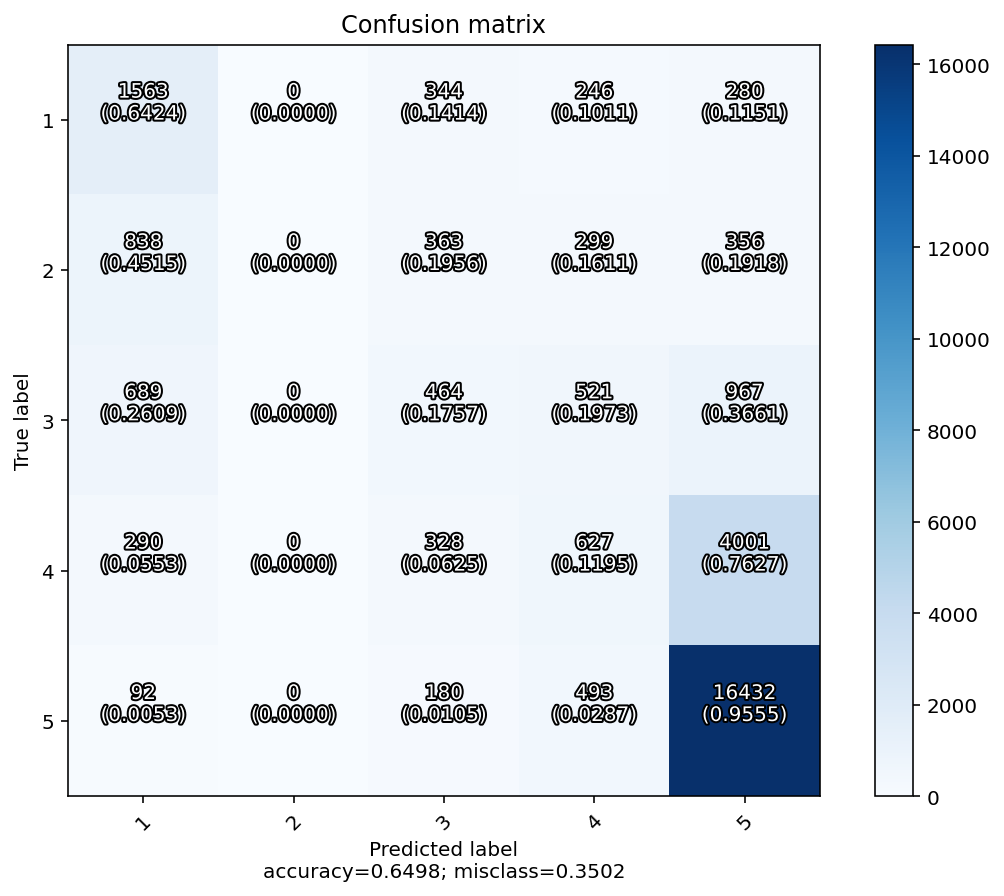

In [52]:
prediction = model.predict(X_eval, batch_size=16)
print(accuracy_score(eval_ratings, np.argmax(prediction, axis=1)))

eval_ratings_pred = np.argmax(prediction, axis=1)
cm = confusion_matrix(eval_ratings, eval_ratings_pred)

plot_confusion_matrix(cm, target_names=[1, 2, 3, 4, 5], title='Confusion matrix')

**Try some measures to overcome the imbalance?**

**Keywords**:
- Undersampling
- Oversampling

## Test

0.6449959094627761


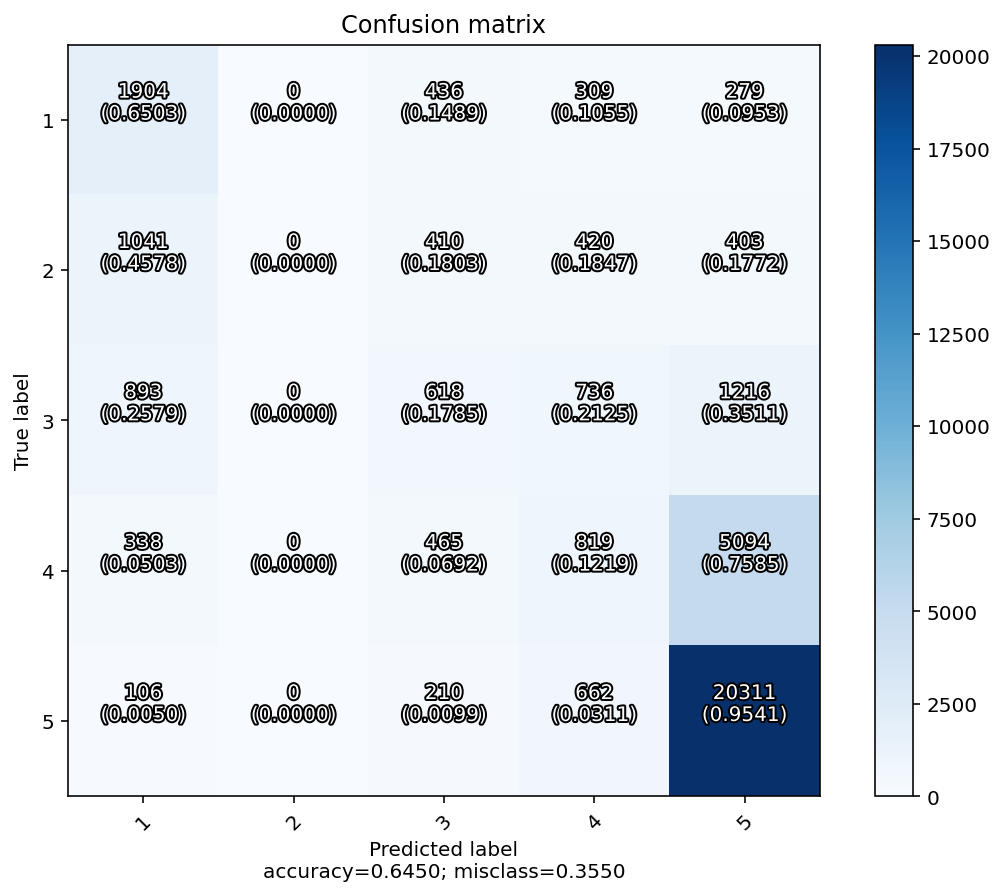

In [54]:
prediction = model.predict(X_test, batch_size=16)
print(accuracy_score(test_ratings, np.argmax(prediction, axis=1)))

test_ratings_pred = np.argmax(prediction, axis=1)
cm = confusion_matrix(test_ratings, test_ratings_pred)

plot_confusion_matrix(cm, target_names=[1, 2, 3, 4, 5], title='Confusion matrix')